In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel
from mahakala.electrons import rlow_rhigh_model
from mahakala.transfer import synchrotron_coefficients, solve_specific_intensity

In [3]:
fname = '../data/torus.mhd_w_bcc.01500.athdf'
bhspin = 0.9
fluid_gamma = 13./9

fluid_model = AthenakFluidModel(fname, bhspin)

100%|██████████| 456/456 [00:00<00:00, 472.08it/s]


In [4]:
observing_frequency = 230.e9
Mass_scale = 5e+24
M_bh = 6.2e9 * 1.989e33
r_high = 40

inclination_in_degrees = 17
distance_in_rg = 1000

fov = 10
number_pixels_across = 80

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)

In [5]:
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

In [6]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S)

100%|██████████| 456/456 [00:02<00:00, 166.98it/s]


In [7]:
# compute supplementary quantities from fluid data and scales

bsq = fluid_scalars['b'] * fluid_scalars['b']

beta = fluid_scalars['u'] * (fluid_gamma - 1.) / bsq / 0.5
beta.at[np.isnan(beta)].set(0.)

sigma = bsq / fluid_scalars['dens']
sigma.at[np.isnan(sigma)].set(0.)

Theta_e = rlow_rhigh_model(fluid_scalars['dens'], fluid_scalars['u'], beta, r_high=r_high)

local_nu = - fluid_scalars['kdotu'] * observing_frequency
gamma_inv_data = local_nu / observing_frequency

units = fluid_model.get_units(M_bh, Mass_scale)

Ne_in_cgs = units['Ne_unit'] * fluid_scalars['dens']
B_in_gauss = units['B_unit'] * fluid_scalars['b']
pitch_angle = fluid_scalars['pitch_angle']

In [8]:
invariant_emissivity, invariant_absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu)

In [15]:
# apply sigma cutoff

sigma_cutoff = 1.

#invariant_emissivity = invariant_emissivity.at[sigma > sigma_cutoff].set(0.)
#invariant_absorptivity = invariant_absorptivity.at[sigma > sigma_cutoff].set(0.)

In [23]:
final_I = solve_specific_intensity(invariant_emissivity, invariant_absorptivity, units['T_unit'] * final_dt, observing_frequency)
final_image = final_I[-1].reshape((number_pixels_across, number_pixels_across))

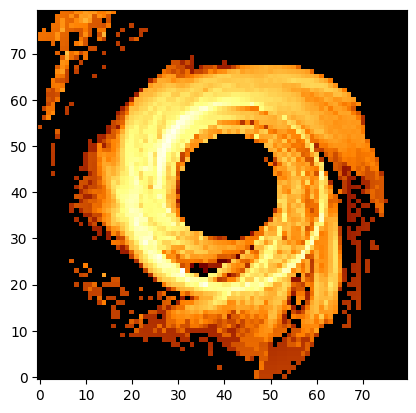

In [24]:
#plt.imshow(np.log10(final_I[-2].reshape(80,80)), origin='lower', cmap='inferno')

I_min = 1.e-10

final_image = final_image / np.max(final_image)
final_image[final_image < I_min] = I_min
final_image[np.isnan(final_image)] = I_min

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')
#ax1.imshow(final_image.T, cmap='afmhot', vmin=0, origin='lower')

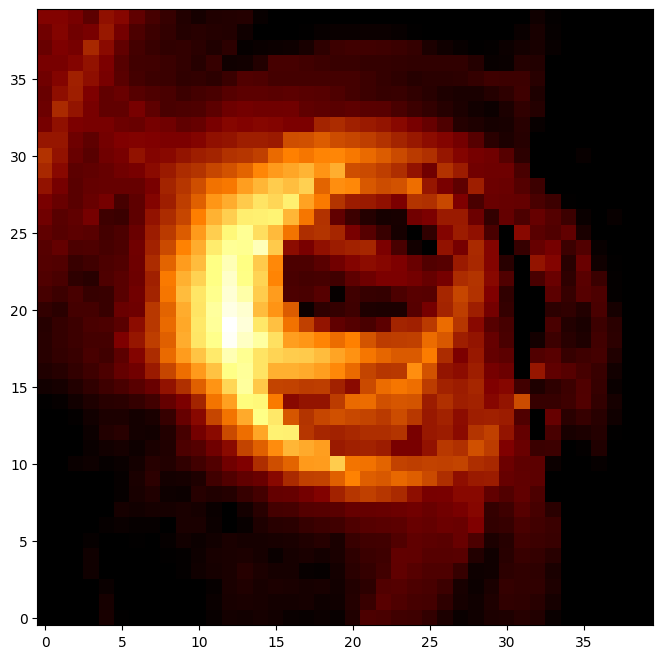

In [33]:
fig = plt.figure(figsize=(8, 8), facecolor='w')

final_image = final_image / np.max(final_image)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')

# checks

In [ ]:
primitive_data_og_40sq = np.load('prim_data_og_40sq.npy', allow_pickle=True).item()

print(np.allclose(primitive_data_og_40sq['dens'], prim_data['dens'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['u'], prim_data['u'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U1'], prim_data['U1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U2'], prim_data['U2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U3'], prim_data['U3'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B1'], prim_data['B1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B2'], prim_data['B2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B3'], prim_data['B3'], atol=1e-3))